FileName: 1.0-run-optimization-model.ipynb

Developer: Tanmoy Das
Date: June 11, 2023 (revised May 2024)

Outline of this script:
1. Input data
2. Run Optimization Model
3. Output in a form of Network Diagram

# Data

In [1]:
# import custom functions
from data_preparation import DataPreparation
import custom_func
from model_d import ModelD
from draw_network import DrawNetworkDiagram
import pandas as pd
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
spill_data = pd.read_excel('../data/processed/data_100_oil_spills.xlsx', sheet_name='spills', header=0).copy()
station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
potential_station_data = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
input_parameters = pd.read_excel('../data/raw/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('../data/gis map/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

In [3]:
# Data Preprocessing
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, CostU \
= DataPreparation.generate_input_data(station_data, spill_data, input_parameters)
coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
coordinates_st = custom_func.extract_station_coordinate(station_data)

coordinates_potential_st = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_potential_st[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize  # (x_0-x_min)/(x_max-x_min)
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20']


In [4]:
# Scalar inputs of the models
DistanceMax = 10
BigM = 10**20
current_vs_proposed = 'proposed' # current
MaxFO = 1
Budget = 10**12
W = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
QuantityMin = 2

DistanceMax_m5 = 10
NumberStMax_m5 = 5

# Run the model

In [5]:
# Model
model_05, select_m5, deploy_m5, mvars_m5, names_m5, values_m5, objValues_m5, \
        spill_df_m5, station_df_m5, cover_1s_m5, select_1s_m5, deploy_1s_m5, MeanResponseTime_m5, coverage_percentage_m5, assignment_m5  \
    = ModelD.solve(Stations, OilSpills, ResourcesD, coordinates_potential_st, coordinates_spill, SizeSpill, SizeSpill_n,
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax_m5, Distance, Distance_n,
          W, QuantityMin, DistanceMax_m5, Cf_s, CostU, Budget,
          BigM, MaxFO)

--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-03
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter LogFile to value "../models/model_moo(May 04,0143).log"
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1832 rows, 1436 columns and 4534 nonzeros
Model fingerprint: 0xa86e4c25
Variable types: 1062 continuous, 374 integer (374 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+25]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 object

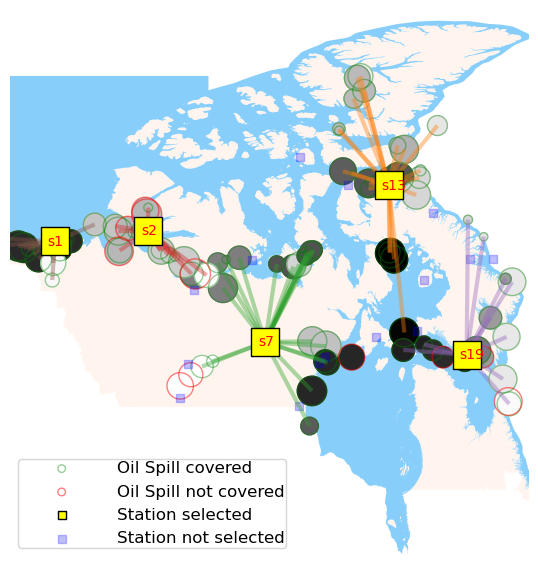

In [6]:
# Fig7a
assignment_line_m5 = DrawNetworkDiagram.draw_network_diagram(DistanceMax_m5, NumberStMax_m5, Sensitivity_R, spill_df_m5, station_df_m5, MeanResponseTime_m5, coverage_percentage_m5, assignment_m5, deploy_1s_m5, select_1s_m5, current_vs_proposed)